### Localization with KNN classifier

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import time
import imutils
import csv
from scipy.spatial import distance
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score


In [2]:
# loading KNN model
knnClassifier = joblib.load('filename.pk1')

In [3]:
# read ground truth localization values

ground_truth_id = []
ground_truth_class = []
ground_truth_coordinates = []

with open('MIO-TCD-Localization/gt_train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        ground_truth_id.append(row[0])
        ground_truth_class.append(row[1])
        coordinates = list(map(int,[row[2],row[3],row[4],row[5]]))
        ground_truth_coordinates.append(coordinates)
        
        if line_count == 0:
            line_count += 1
        else:
            line_count += 1
            
ground_truth_id = np.array(ground_truth_id)
ground_truth_class = np.array(ground_truth_class)
ground_truth_coordinates = np.array(ground_truth_coordinates)

In [4]:
def getHogFeatures(images):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins
    
    hog = cv2.HOGDescriptor(_winSize=(images[0].shape[1] // cell_size[1] * cell_size[1],
                                          images[0].shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
    
    n_cells = (images[0].shape[0] // cell_size[0], images[0].shape[1] // cell_size[1])
    
    listOfHogFeatures = []
    for img in images:
        # create HoG Object
        # winSize is the size of the image cropped to an multiple of the cell size
        

        # Compute HoG features
        hog_feats = hog.compute(img)\
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[0], block_size[1], nbins) \
                       .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

        # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
        # Indexing is by rows then columns.
        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        # turn gradient 32,32,8 3D array to 1D for training 
        reshaped_gradients = gradients.ravel()
        listOfHogFeatures.append(reshaped_gradients)
        
    return listOfHogFeatures

In [5]:
def calculate_dice_coefficient(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return dice coefficient based on intersection of union
    dice_coefficient = (2 * iou)/(iou + 1)
    return dice_coefficient

In [6]:
# extract images from localization
def extract_localization_images(path, extracted_images, extracted_value, image_ids):
    extracted_count = 0
    test_count = 0
    
    ## resize images to 128x128 grayscale 
    for file in os.listdir(path):
    # grab only 1 images from train directory for testing purposes 
        if (extracted_count < extracted_value):
            img = cv2.cvtColor(cv2.imread(os.path.join(path + "/" + file)), cv2.COLOR_BGR2GRAY)
            print(img.shape)
            extracted_images.append(img)
            extracted_count = extracted_count + 1 
            image_ids.append(""+file[:-4])
            
        else:
            break
                            
    return extracted_images


In [7]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [8]:
def draw_gt_values(img, class_coordinates):
    
    for coordinates in class_coordinates:
        xy = (int(coordinates[0]), int(coordinates[1]))
        w = int(coordinates[2])
        h = int(coordinates[3])
        cv2.rectangle(img, xy, (w,h), (0,255,0), 2)
    

In [9]:
def get_ground_truth_values(image_id):
    classes = ground_truth_class[ground_truth_id == image_id]
    class_coordinates = ground_truth_coordinates[ground_truth_id == image_id]
    return classes, class_coordinates

In [10]:
def multi_scale_sliding_window(localization_image, img, window_width, window_height, step_size, window_scales):
    patches = []
    patches_coordinates = []
    patches_classes = []
    
    # loop over different window scales
    for scale in window_scales:
        window_size = (int(window_width * scale), int(window_height * scale))
        color = tuple(np.random.randint(0, 255, 3).tolist())
        for (x, y, window) in sliding_window(localization_image, stepSize=step_size, windowSize=window_size):
            # if the window does not meet our desired window size, ignore it
            if window.shape[0] < int(window_width*scale) or window.shape[1] < int(window_height*scale):
                continue
            
            resized_window = cv2.resize(window,(window_width,window_height))
            window_hog_features = getHogFeatures([resized_window])
            prediction = knnClassifier.predict(window_hog_features)
            
            if (prediction != "background"):
                cv2.rectangle(img, (x, y), (x + int(window_width*scale), y + int(window_height*scale)), color, 2)
            
                patches.append(window)
                patches_coordinates.append([x,y,x+int(window_width*scale),y+int(window_width*scale)])
                patches_classes.append(prediction)
        
    return patches, patches_coordinates, patches_classes

In [11]:
# calculate best MEAN coefficient from best bounding boxes.

def calculate_localization_results(localization_image, gt_classes, gt_class_coordinates, patches, patches_coordinates, patches_classes):
    dice_coefficient_values = []
    prediction_results = []

    for gt_class, gt_coordinates in zip(gt_classes, gt_class_coordinates):
        closest_coordinates = []
        for patch, p_coordinates in zip(patches, patches_coordinates):
            distance_from_gt = distance.euclidean(p_coordinates, gt_coordinates)
            closest_coordinates.append(distance_from_gt)
        
        if (closest_coordinates):
            closest_coordinates = np.array(closest_coordinates)
            min_index = np.argmin(closest_coordinates)
            min_coordinates = patches_coordinates[min_index]

            dice_coefficient = calculate_dice_coefficient(min_coordinates, gt_coordinates)
            dice_coefficient_values.append(dice_coefficient)

            prediction_results.append(patches_classes[min_index])

            cv2.rectangle(localization_image,(min_coordinates[0],min_coordinates[1]), (min_coordinates[2],min_coordinates[3]), (0,0,255), 2) 
    
    if(dice_coefficient_values):
        mean_dice_coefficient = np.mean(dice_coefficient_values)
        return mean_dice_coefficient, prediction_results
    else:
        return [],[]

#### KNN LOCALIZATION

In [12]:
training_set_path= r"./MIO-TCD-Localization/train"
train_images = []
train_value = 1
image_ids = []

extract_localization_images(training_set_path, train_images, train_value,image_ids)
print(len(train_images))
print(len(image_ids))

(228, 342)
1
1


In [13]:
# localize all vehicles in each image

dice_coefficient_images = []
all_class_predictions = []
all_ground_truth_classes = []

window_width = 64
window_height = 64
step_size = 32 
window_scales = [0.75,1,1.25,1.5]

for localization_image, image_id in zip(train_images,image_ids):
    
    gt_classes, gt_class_coordinates = get_ground_truth_values(image_id)

    img = cv2.imread(r"./MIO-TCD-Localization/train/"+ str(image_id) + ".jpg")
    patches, patches_coordinates, patches_classes = multi_scale_sliding_window(localization_image, img, window_width, window_height, step_size, window_scales)

    patches_classes = np.array(patches_classes)
    draw_gt_values(img, gt_class_coordinates)

    localization_image_dice, class_predictions = calculate_localization_results(img, gt_classes, gt_class_coordinates, patches, patches_coordinates, patches_classes)
    dice_coefficient_images.append(localization_image_dice)

    for prediction in class_predictions:
        all_class_predictions.append(prediction)
    for gt_class in gt_classes:
        all_ground_truth_classes.append(gt_class)

    cv2.imwrite("./knn_localization/" + str(image_id)+"_knn" + ".jpg",img)
#plt.imshow(img)
    

ValueError: x and y must have same first dimension, but have shapes (24,) and (1,)

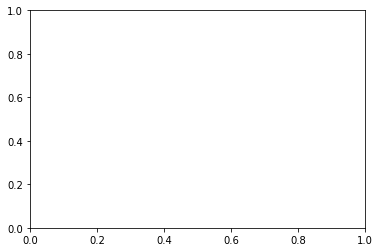

In [14]:
# distribution of dice coefficient 
image_index = []
for i in range(len(train_images)):
    image_index.append(i)
    
plt.plot(image_index,dice_coefficient_images)
plt.axis([0, len(image_index), 0, 1])
plt.show()

In [ ]:
all_class_predictions = np.array(all_class_predictions)
all_ground_truth_classes = np.array(all_ground_truth_classes)

# determine accuracy,recall,precision
accuracy = accuracy_score(all_class_predictions, all_ground_truth_classes)
print("AVERAGE LOCALIZATION + KNN CLASSIFICATION ACCURACY : ", str(accuracy* 100) + " %")
precision = precision_score(all_class_predictions, all_ground_truth_classes, average = 'micro')
print("AVERAGE LOCALIZATION + KNN CLASSIFICATION PRECISION : ", str(precision* 100) + " %")
recall = recall_score(all_class_predictions, all_ground_truth_classes, average='micro')
print("AVERAGE LOCALIZATION + KNN CLASSIFICATION RECALL : ", str(recall* 100) + " %")

